# VGG16
This notebook is part of the waste image classification project.

Here we explore the viability of the pre-trained VGG16 model for waste image classification.

In [1]:
import os
import shutil
import pickle

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array, load_img)
from tensorflow.keras import callbacks, models, layers, losses

from azureml.core import Workspace, Dataset, ScriptRunConfig
from azureml.tensorboard import Tensorboard
from azureml.core.environment import Environment

from tensorflow.keras.applications.vgg16 import VGG16

from utils import log_runs, visualize_log, plot_accuracy

# Setup

Load in the resources created in the first notebook and setup for this set of experiments.

In [2]:
# Load the stored workspace
ws = Workspace.from_config()

In [3]:
# Get the registered dataset from azure
dataset = Dataset.get_by_name(ws, name='waste_images')

In [4]:
## Try with our saved image
env = Environment.get(workspace=ws, name="waste-env-gpu")

In [5]:
# get our compoute cluster
# for cnn we will use a gpu cluster
compute_name = "gpu-cluster-NC6"
compute_target = ws.compute_targets[compute_name]

In [6]:
# set the expiriment
experiment_name = 'vgg16'
from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

In [7]:
script_path = 'vgg16_train_script/'

if not os.path.exists(script_path):
    os.mkdir(script_path)

# move the file to the upload dir
shutil.copy('utils.py', script_path)


'vgg16_train_script/utils.py'

# Inspect VGG16
Check which layers are missing in the headless version of the model.

In [8]:
vgg = VGG16()
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
vgg_headless = VGG16(include_top=False)
vgg_headless.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

From this comparison we can see that the headless model is missing:
- a flattening layer
- two fully connected layers
- and an output predicion layer

We will add those to the control script for training.

## Write control script

The control script will be uploaded to aml instances in azure.  Images are cached in Azure, so parameterizing the script results in faster run times than submitting new scrips for each run.  It also allows for faster iteration

In [10]:
%%writefile vgg16_train_script/train.py

import argparse
import os
import shutil
import numpy as np
import pickle

from azureml.core import Run
from azureml.core import Workspace, Dataset

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array)
from tensorflow.keras import callbacks
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.applications.vgg16 import VGG16

from utils import count_files

# set seed for reproducibility
np.random.seed(867)

# output will be logged, separate output from previous log entries.
print('-'*100)

# parse the parameters passed to the this script
parser = argparse.ArgumentParser()
parser.add_argument('--data_path', type=str, 
                    dest='data_path', 
                    default='data', 
                    help='data folder mounting point')
    
parser.add_argument('--dense_nodes', 
                    type=str, 
                    dest='dense_nodes', 
                    default='32', 
                    help='number of nodes in each layer (comma separated)')
parser.add_argument('--dense_activations', 
                    type=str, 
                    dest='dense_activations', 
                    default='relu', 
                    help='activation function to use on hidden layers (comma separated)')

parser.add_argument('--optimizer', 
                    type=str, 
                    dest='optimizer', 
                    default='sgd', 
                    help='optimizer to use')
parser.add_argument('--epochs', 
                    type=int, 
                    dest='epochs', 
                    default=5, 
                    help='number of epochs to try.')
args = parser.parse_args()

# split list args into lists
dense_nodes = args.dense_nodes.split(',')
dense_activations = args.dense_activations.split(',')

# print to log for debuggig if necessary
print('Data folder:',args.data_path)

print('Dense Nodes:', dense_nodes)
print('Dense Activations:', dense_activations)

# get azure run context
run = Run.get_context()
print('Environment:',run.get_environment().name)


# set data paths
train_folder = os.path.join(args.data_path, 'train')
val_folder = os.path.join(args.data_path, 'validation')
test_folder = os.path.join(args.data_path, 'test')

# count the number of files in each split
num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)

# print number of files in each split to log
print('Num Train Files:', num_train)
print('Num Val Files:', num_val)
print('Num Test Files:', num_test)


# Create generators for importing the images
print('Creating train ImageDataGenerator')
train_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(train_folder,
                                             target_size = (244, 244),
                                             batch_size = 32)
print('Creating validation ImageDataGenerator')
val_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(val_folder,
                                             target_size = (244, 244),
                                             batch_size = num_val)
print('Creating test ImageDataGenerator')
test_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(test_folder,
                                             target_size = (244, 244),
                                             batch_size = num_test)

# model callbacks
my_callbacks = [
    callbacks.EarlyStopping(patience=3),
    callbacks.ModelCheckpoint(filepath=f'outputs/{run.id}.h5',
                              save_best_only=True),
    callbacks.TensorBoard(log_dir=f'logs/{run.properties["name"]}/',
                          histogram_freq=1,
                          profile_batch=0)
]



# Build the model
model = models.Sequential()

VGG = VGG16(weights='imagenet', include_top=False, input_shape=(244,244,3))

# Freeze Model
VGG.trainable = False

model.add(VGG)
model.add(layers.Flatten())

# create hidden layers based on parameters
for node, activation in zip(dense_nodes, dense_activations):
    print(f'Creating Dense layer with {node} nodes and activation={activation}')
    model.add(layers.Dense(node, activation=activation))

# final layer for classification
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=args.optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

# fit model and store history
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=args.epochs,
                    callbacks=my_callbacks)

print('Saving model history...')
with open(f'outputs/{run.id}.history', 'wb') as f:
    pickle.dump(history.history, f)

# print model summary to log
model.summary()

print('evaluating model on test set...')
model_val = model.evaluate(test_generator)

print('Test Loss:', model_val[0])
print('Test Accuracy:', model_val[1])

run.log('test_loss', np.float(model_val[0]))
run.log('test_accuracy', np.float(model_val[1]))

print('Done!')
print('-'*100)

Overwriting vgg16_train_script/train.py


## Iterate models

Now that we have a control script we can start submitting runs of various models to azure compute.  They will run asynchronously in parallel which will make this process comparatively fast.

In [11]:
# create var to stor run objects
runs = []

## Model 1
* activation: relu
- optimizer: SGD

In [12]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--dense_nodes', '4096,4096',
        '--dense_activations', 'relu,relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [13]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'vgg16-relu-sgd'})

runs[-1].tag('class', 'VGG16')
runs[-1].tag('activation', 'relu')
runs[-1].tag('optimizer', 'sgd')

## Model 2
Activation: relu
Optimizer: Adam

In [14]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--dense_nodes', '4096,4096',
        '--dense_activations', 'relu,relu',
        '--optimizer', 'adam',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [15]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'vgg16-relu-adam'})

runs[-1].tag('class', 'VGG16')
runs[-1].tag('activation', 'relu')
runs[-1].tag('optimizer', 'adam')

## Model 3
* Activation: relu
* Optimizer: SGD

In [16]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--dense_nodes', '4096,4096',
        '--dense_activations', 'relu,relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [17]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'vgg16-relu-sgd'})

runs[-1].tag('class', 'VGG16')
runs[-1].tag('activation', 'relu')
runs[-1].tag('optimizer', 'sgd')

## Model 4
* Activation: sigmoid
* Optimizer: Adam

In [18]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--dense_nodes', '4096,4096',
        '--dense_activations', 'sigmoid,sigmoid',
        '--optimizer', 'adam',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [19]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'vgg16-sigmoid-adam'})

runs[-1].tag('class', 'VGG16')
runs[-1].tag('activation', 'sigmoid')
runs[-1].tag('optimizer', 'adam')

## Start Tensorboard to monitor the runs

In [20]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [21]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

## Evaluate Models

In [22]:
# make sure all runs are complete
for run in runs:
    run.wait_for_completion(show_output=False, 
                            wait_post_processing=True, 
                            raise_on_error=True)

In [23]:
log = log_runs(runs, 'vgg16')
log

{'test_loss': 0.9735111594200134, 'test_accuracy': 0.6693548560142517}

{'test_loss': 1.0545791387557983, 'test_accuracy': 0.725806474685669}

{'test_loss': 1.2966604232788086, 'test_accuracy': 0.5887096524238586}

{'test_loss': 0.9026638269424438, 'test_accuracy': 0.7580645084381104}

,name,type,runtime,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
vgg16_1615998050_1d5ebfaf,vgg16-relu-sgd,vgg16,00:10:29.982880,0.973511,0.669355,"[1.835109829902649, 1.306679129600525, 1.20127...","[0.3582746386528015, 0.46919015049934387, 0.53...","[1.2348053455352783, 1.0419665575027466, 0.977...","[0.6412213444709778, 0.6335877776145935, 0.580..."
vgg16_1615998063_03356be7,vgg16-relu-adam,vgg16,00:08:15.961259,1.054579,0.725806,"[3.6813862323760986, 0.629645586013794, 0.3784...","[0.4775528311729431, 0.7711267471313477, 0.866...","[0.6805471181869507, 0.6547092795372009, 0.748...","[0.7557252049446106, 0.7633587718009949, 0.748..."
vgg16_1615998066_8e4e8ce3,vgg16-relu-sgd,vgg16,00:16:33.823339,1.296660,0.588710,"[1.7136633396148682, 1.2780202627182007, 1.161...","[0.35079225897789, 0.4960387349128723, 0.54665...","[1.3049980401992798, 1.0312479734420776, 0.973...","[0.4122137427330017, 0.572519063949585, 0.6946..."
vgg16_1615998071_817495e4,vgg16-sigmoid-adam,vgg16,00:10:53.899273,0.902664,0.758065,"[2.556894302368164, 1.020498514175415, 0.69135...","[0.31954225897789, 0.5792253613471985, 0.75572...","[1.3884254693984985, 0.7647875547409058, 0.585...","[0.4122137427330017, 0.6870229244232178, 0.748..."


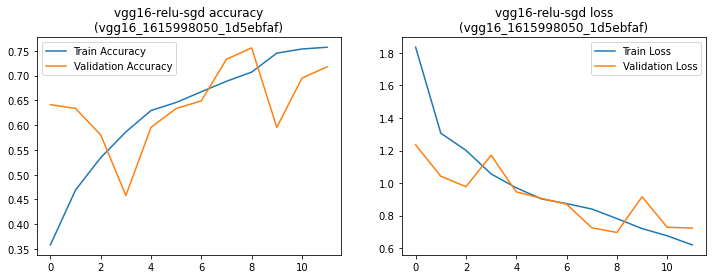

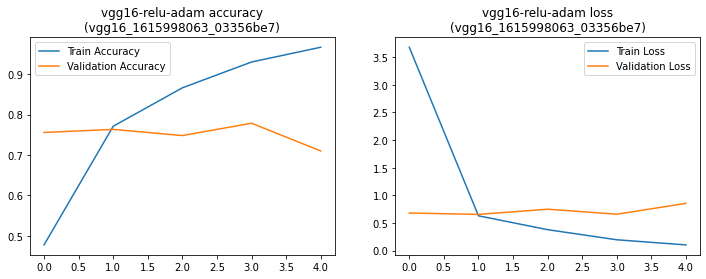

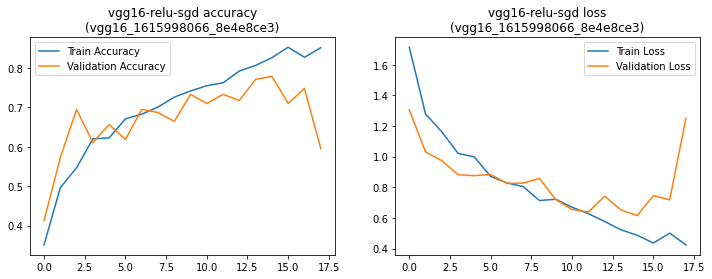

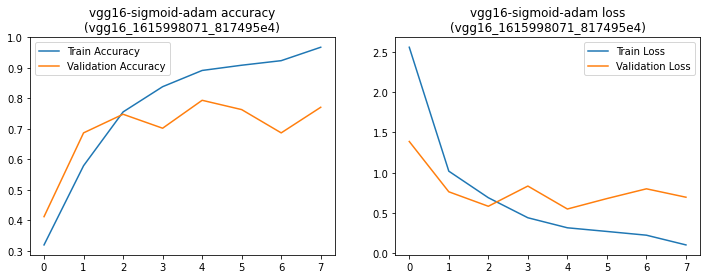

In [24]:
visualize_log(log)

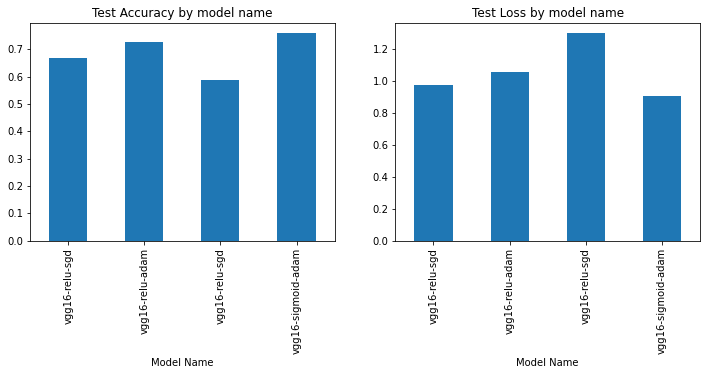

In [25]:
plot_accuracy(log)

## Comments
The sigmoid activation with adam optimizer performed fairly well.  This is significantly better than the CNN models.  More could be done with image augmentation and fine tuning with a lower learning rate but for now I will move on to test another pre;trained model: [Xception](5_Xception_Azure.ipynb) model.